# Perturbed satellite orbit
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example demonstrates the propagation of a (quasi-massless) body dominated by a central point-mass attractor, but also including multiple perturbing accelerations exerted by the central body as well as third bodies.

The example showcases the ease with which a simulation environment can be extended to a multi-body system. It also demonstrates the wide variety of acceleration types that can be modelled using the propagation_setup.acceleration module, including accelerations from non-conservative forces such as drag and radiation pressure. Note that the modelling of these acceleration types requires special environment interfaces (implemented via `add_aerodynamic_coefficient_interface()`, `add_radiation_pressure_interface()`) of the body undergoing the accelerations.

It also demonstrates and motivates the usage of dependent variables. By keeping track of such variables throughout the propagation, valuable insight, such as contributions of individual acceleration types, ground tracks or the evolution of Kepler elements, can be derived in the post-propagation analysis.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# Load standard modules
import numpy as np
# make plots interactive
%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.astro import element_conversion
from tudatpy.kernel import constants
from tudatpy.util import result2array

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth can be make known to `tudatpy`.

Then, the start and end simulation epochs are setups. In this case, the start epoch is set to `0`, corresponding to the 1st of January 2000. The times should be specified in seconds since J2000.
Please refer to the API documentation of the `time_conversion module` [here](https://tudatpy.readthedocs.io/en/latest/time_conversion.html) for more information on this.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = 0.0
simulation_end_epoch = constants.JULIAN_DAY

## Environment setup
Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the bodies
Bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

The default body settings (such as atmosphere, body shape, rotation model) are taken from `SPICE`.

These settings can be adjusted. Please refere to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [3]:
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

# Create system of selected celestial bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Create the vehicle
Let's now create the 400kg satellite for which the perturbed orbit around Earth will be propagated.

In [4]:
# Create vehicle objects.
bodies.create_empty_body("Delfi-C3")

bodies.get("Delfi-C3").mass = 400.0

To account for the aerodynamic of the satellite, let's add an aerodynamic interface and add it to the environment setup, taking the followings into account:
- A constant drag coefficient of 1.2.
- A reference area of 4m$^2$.
- No sideslip or lift coefficient (equal to 0).
- No moment coefficient.

In [5]:
# Create aerodynamic coefficient interface settings, and add to vehicle
reference_area = 4.0
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0, 0]
)
environment_setup.add_aerodynamic_coefficient_interface(
    bodies, "Delfi-C3", aero_coefficient_settings)

To account for the pressure of the solar radiation on the satellite, let's add another interface. This takes a radiation pressure coefficient of 1.2, and a radiation area of 4m$^2$. This interface also accounts for the variation in pressure cause by the shadow of Earth.

In [6]:
# Create radiation pressure settings, and add to vehicle
reference_area_radiation = 4.0
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
environment_setup.add_radiation_pressure_interface(
    bodies, "Delfi-C3", radiation_pressure_settings)

## Propagation setup
Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [7]:
# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
First off, the acceleration settings that act on `Delfi-C3` are to be defined.
In this case, these consist in the followings:
- Graviational acceleration of Earth modeled as Spherical Harmonics, taken up to a degree and order 5.
- Gravitational acceleration of the Sun, the Moon, Mars, and Venus, modeled as a Point Mass.
- Aerodynamic acceleration caused by the atmosphere of the Earth (using the aerodynamic interface defined earlier).
- Radiation pressure acceleration caused by the Sun (using the radiation interface defined earlier).

The acceleration settings defined are then applied to `Delfi-C3` in a dictionary.

This dictionary is finally input to the propagation setup to create the acceleration models.

In [8]:
# Define accelerations acting on Delfi-C3 by Sun and Earth.
accelerations_settings_delfi_c3 = dict(
    Sun=[
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        propagation_setup.acceleration.aerodynamic()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Venus=[
        propagation_setup.acceleration.point_mass_gravity()
    ]
)

# Create global accelerations settings dictionary.
acceleration_settings = {"Delfi-C3": accelerations_settings_delfi_c3}

# Create acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

### Define the initial state
The initial state of the vehicle that will be propagated is now defined. 

This initial state always has to be provided as a cartesian state, in the form of a list with the first three elements reprensenting the initial position, and the three remaining elements representing the initial velocity.

In this case, let's make use of the `keplerian_to_cartesian_elementwise()` function that is included in the `element_conversion` module, so that the initial state can be input as Keplerian elements, and then converted in Cartesian elements.

In [9]:
# Set initial conditions for the satellite that will be
# propagated in this simulation. The initial conditions are given in
# Keplerian elements and later on converted to Cartesian elements
earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis=7500.0e3,
    eccentricity=0.1,
    inclination=np.deg2rad(85.3),
    argument_of_periapsis=np.deg2rad(235.7),
    longitude_of_ascending_node=np.deg2rad(23.4),
    true_anomaly=np.deg2rad(139.87),
)

### Define dependent variables to save
In this example, we are interested in saving not only the propagated state of the satellite over time, but also a set of so-called dependent variables, that are to be computed (or extracted and saved) at each integration step.

[This page](https://tudatpy.readthedocs.io/en/latest/dependent_variable.html) of the tudatpy API website provides a detailled explanation of all the dependent variables that are available.

In [10]:
# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration("Delfi-C3"),
    propagation_setup.dependent_variable.keplerian_state("Delfi-C3", "Earth"),
    propagation_setup.dependent_variable.latitude("Delfi-C3", "Earth"),
    propagation_setup.dependent_variable.longitude("Delfi-C3", "Earth"),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Sun"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Moon"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Mars"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "Delfi-C3", "Venus"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "Delfi-C3", "Earth"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.aerodynamic_type, "Delfi-C3", "Earth"
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.cannonball_radiation_pressure_type, "Delfi-C3", "Sun"
    )
]

### Create the propagator settings
The propagator is finally setup.

First, a termination condition is defined so that the propagation will stop when the end epochs that was defined is reached.

Then, the translational propagator settings are defined. These are used to simulate the orbit of `Delfi-C3` around Earth.

In [11]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    termination_condition,
    output_variables=dependent_variables_to_save
)

### Create the integrator settings
The last step before starting the simulation is to setup the integrator that will be used.

In this case, a RK4 integrator is used with a step fixed at 10 seconds.

In [12]:
# Create numerical integrator settings
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    simulation_start_epoch, fixed_step_size
)

## Propagate the orbit
The orbit is now ready to be propagated.

This is done by calling the `SingleArcSimulator()` function of the `numerical_simulation module`.
This function requires the `bodies`, `integrator_settings`, and `propagator_settings` that have all been defined earlier.

After this, the history of the propagated state over time, containing both the position and velocity history, is extracted.
This history, taking the form of a dictionary, is then converted to an array containing 7 columns:
- Column 0: Time history, in seconds since J2000.
- Columns 1 to 3: Position history, in meters, in the frame that was specified in the `body_settings`.
- Columns 4 to 6: Velocity history, in meters per second, in the frame that was specified in the `body_settings`.

The same is done with the dependent variable history. The column indexes corresponding to a given dependent variable in the `dep_vars` variable are printed when the simulation is run, when `SingleArcSimulator()` is called.
Do mind that converting to an ndarray using the `result2array()` utility will shift these indexes, since the first column (index 0) will then be the times.

In [13]:
# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.SingleArcSimulator(
    bodies, integrator_settings, propagator_settings
)

# Extract the resulting state and depedent variable history and convert it to an ndarray
states = dynamics_simulator.state_history
states_array = result2array(states)
dep_vars = dynamics_simulator.dependent_variable_history
dep_vars_array = result2array(dep_vars)

State vector contains: 
Vector entries, Vector contents
[0:6], translational state of body Delfi-C3
Dependent variables being saved, output vector contains: 
Vector entry, Vector contents
0, Total acceleration in inertial frame of Delfi-C3
3, Kepler elements of Delfi-C3 w.r.t. Earth
9, Spherical position angle latitude angle of Delfi-C3 w.r.t. Earth
10, Spherical position angle longitude angle of Delfi-C3 w.r.t. Earth
11, Single acceleration norm of type central gravity , acting on Delfi-C3, exerted by Sun
12, Single acceleration norm of type central gravity , acting on Delfi-C3, exerted by Moon
13, Single acceleration norm of type central gravity , acting on Delfi-C3, exerted by Mars
14, Single acceleration norm of type central gravity , acting on Delfi-C3, exerted by Venus
15, Single acceleration norm of type spherical harmonic gravity , acting on Delfi-C3, exerted by Earth
16, Single acceleration norm of type aerodynamic , acting on Delfi-C3, exerted by Earth
17, Single acceleration

## Post-process the propagation results
The results of the propagation are then processed to a more user-friendly form.

### Total acceleration over time
Let's first plot the total acceleration on the satellite over time. This can be done by taking the norm of the first three columns of the dependent variable list.

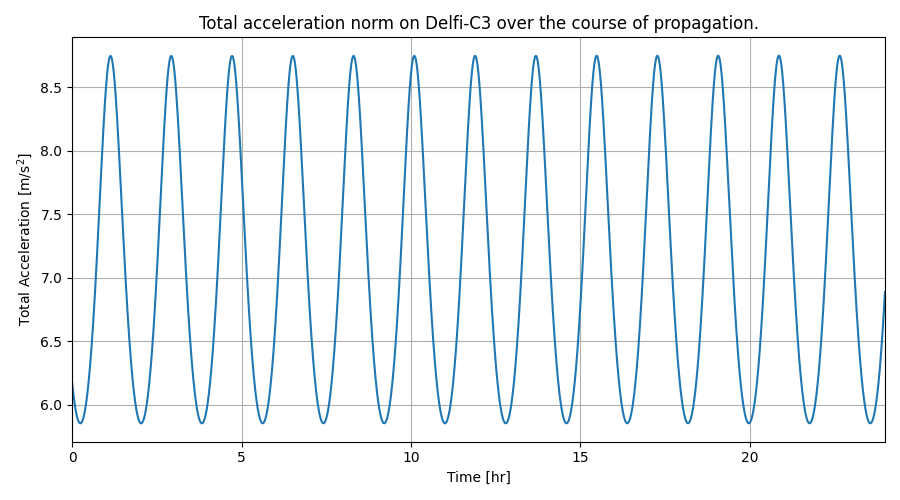

In [14]:
# Plot total acceleration as function of time
time_hours = dep_vars_array[:,0]/3600
total_acceleration_norm = np.linalg.norm(dep_vars_array[:,1:4], axis=1)
plt.figure(figsize=(9, 5))
plt.title("Total acceleration norm on Delfi-C3 over the course of propagation.")
plt.plot(time_hours, total_acceleration_norm)
plt.xlabel('Time [hr]')
plt.ylabel('Total Acceleration [m/s$^2$]')
plt.xlim([min(time_hours), max(time_hours)])
plt.grid()
plt.tight_layout()

### Ground track
Let's then plot the ground track of the satellite in its first 3 hours. This makes use of the latitude and longitude dependent variables.

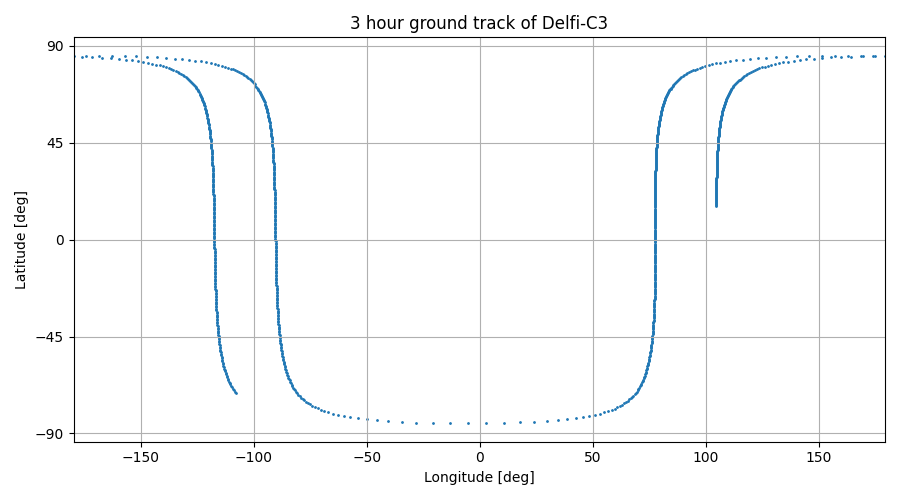

In [15]:
# Plot ground track for a period of 3 hours
latitude = dep_vars_array[:,10]
longitude = dep_vars_array[:,11]
hours = 3
subset = int(len(time_hours) / 24 * hours)
latitude = np.rad2deg(latitude[0: subset])
longitude = np.rad2deg(longitude[0: subset])
plt.figure(figsize=(9, 5))
plt.title("3 hour ground track of Delfi-C3")
plt.scatter(longitude, latitude, s=1)
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.xlim([min(longitude), max(longitude)])
plt.yticks(np.arange(-90, 91, step=45))
plt.grid()
plt.tight_layout()

### Kepler elements over time
Let's now plot each of the 6 Kepler element as a function of time, also as saved in the dependent variables.

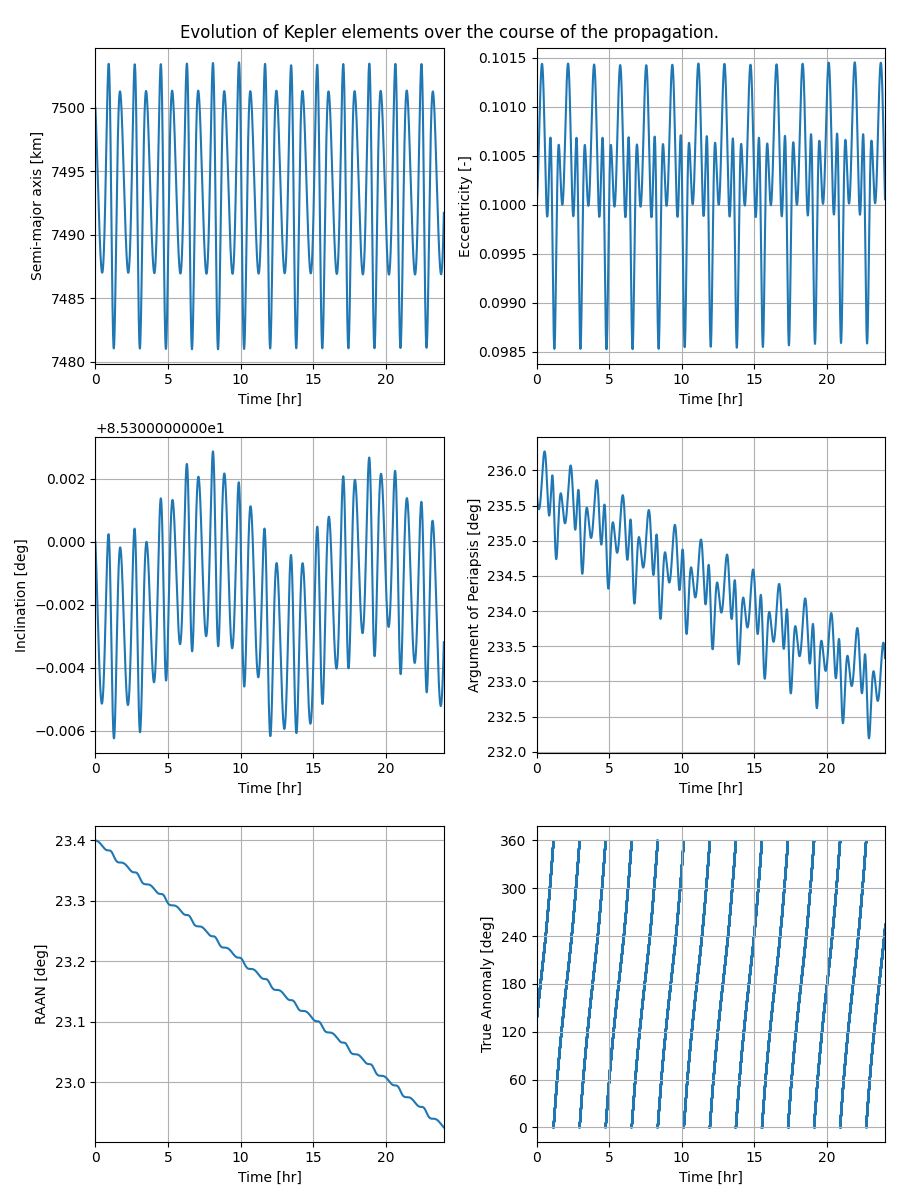

In [16]:
# Plot Kepler elements as a function of time
kepler_elements = dep_vars_array[:,4:10]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9, 12))
fig.suptitle('Evolution of Kepler elements over the course of the propagation.')

# Semi-major Axis
semi_major_axis = kepler_elements[:,0] / 1e3
ax1.plot(time_hours, semi_major_axis)
ax1.set_ylabel('Semi-major axis [km]')

# Eccentricity
eccentricity = kepler_elements[:,1]
ax2.plot(time_hours, eccentricity)
ax2.set_ylabel('Eccentricity [-]')

# Inclination
inclination = np.rad2deg(kepler_elements[:,2])
ax3.plot(time_hours, inclination)
ax3.set_ylabel('Inclination [deg]')

# Argument of Periapsis
argument_of_periapsis = np.rad2deg(kepler_elements[:,3])
ax4.plot(time_hours, argument_of_periapsis)
ax4.set_ylabel('Argument of Periapsis [deg]')

# Right Ascension of the Ascending Node
raan = np.rad2deg(kepler_elements[:,4])
ax5.plot(time_hours, raan)
ax5.set_ylabel('RAAN [deg]')

# True Anomaly
true_anomaly = np.rad2deg(kepler_elements[:,5])
ax6.scatter(time_hours, true_anomaly, s=1)
ax6.set_ylabel('True Anomaly [deg]')
ax6.set_yticks(np.arange(0, 361, step=60))

for ax in fig.get_axes():
    ax.set_xlabel('Time [hr]')
    ax.set_xlim([min(time_hours), max(time_hours)])
    ax.grid()
plt.tight_layout()

### Accelerations over time
Finally, let's plot and compare each of the included accelerations.

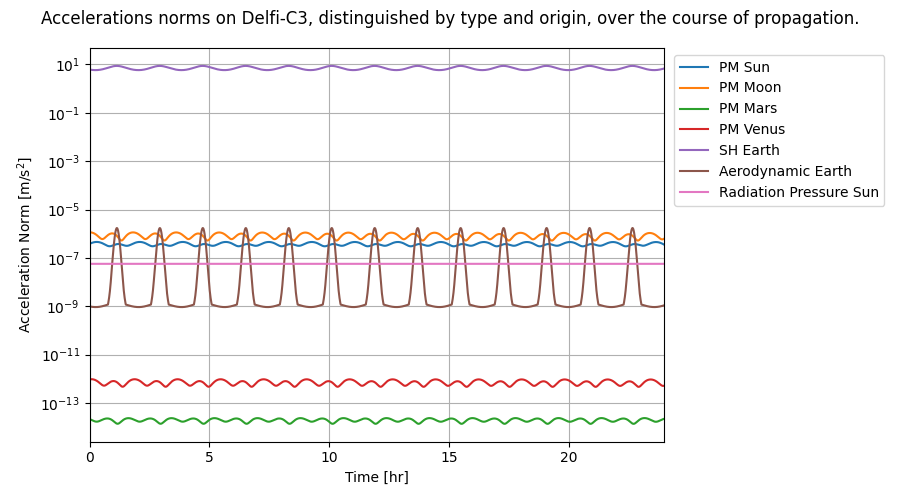

In [17]:
plt.figure(figsize=(9, 5))

# Point Mass Gravity Acceleration Sun
acceleration_norm_pm_sun = dep_vars_array[:,12]
plt.plot(time_hours, acceleration_norm_pm_sun, label='PM Sun')

# Point Mass Gravity Acceleration Moon
acceleration_norm_pm_moon = dep_vars_array[:,13]
plt.plot(time_hours, acceleration_norm_pm_moon, label='PM Moon')

# Point Mass Gravity Acceleration Mars
acceleration_norm_pm_mars = dep_vars_array[:,14]
plt.plot(time_hours, acceleration_norm_pm_mars, label='PM Mars')

# Point Mass Gravity Acceleration Venus
acceleration_norm_pm_venus = dep_vars_array[:,15]
plt.plot(time_hours, acceleration_norm_pm_venus, label='PM Venus')

# Spherical Harmonic Gravity Acceleration Earth
acceleration_norm_sh_earth = dep_vars_array[:,16]
plt.plot(time_hours, acceleration_norm_sh_earth, label='SH Earth')

# Aerodynamic Acceleration Earth
acceleration_norm_aero_earth = dep_vars_array[:,17]
plt.plot(time_hours, acceleration_norm_aero_earth, label='Aerodynamic Earth')

# Cannonball Radiation Pressure Acceleration Sun
acceleration_norm_rp_sun = dep_vars_array[:,18]
plt.plot(time_hours, acceleration_norm_rp_sun, label='Radiation Pressure Sun')

plt.xlim([min(time_hours), max(time_hours)])
plt.xlabel('Time [hr]')
plt.ylabel('Acceleration Norm [m/s$^2$]')

plt.legend(bbox_to_anchor=(1.005, 1))
plt.suptitle("Accelerations norms on Delfi-C3, distinguished by type and origin, over the course of propagation.")
plt.yscale('log')
plt.grid()
plt.tight_layout()